# Loss Functions

## Schritt 1: Categorical Cross-Entropy loss berechnen

In [3]:
import math

In [4]:
softmax_output = [0.7, 0.1, 0.2]
target_output = [1, 0, 0]

In [5]:
loss = -(
    math.log(softmax_output[0]) * target_output[0]+
    math.log(softmax_output[1]) * target_output[1]+
    math.log(softmax_output[2]) * target_output[2]
)
print(loss)

0.35667494393873245


In [6]:
loss_simple = -math.log(softmax_output[0])
print(loss_simple)

0.35667494393873245


### Log Funktion reminder

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
sns.set_context("talk")

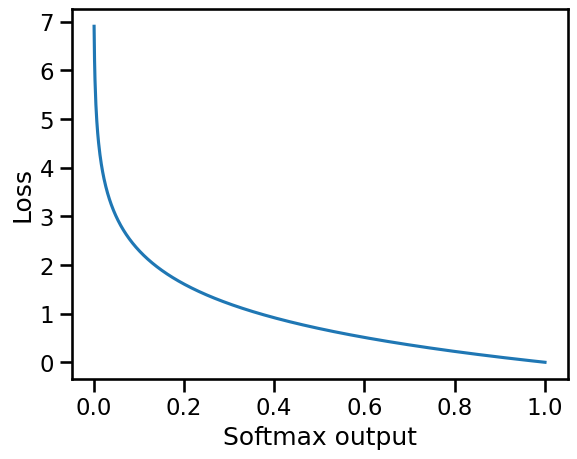

In [11]:
x = np.linspace(0.001, 1, 1000)
y = -np.log(x)

f, ax = plt.subplots(1)
ax.plot(x, y)

_ = ax.set_xlabel("Softmax output")
_ = ax.set_ylabel("Loss")

## Schritt 2: Mehrere Samples

In [12]:
class Activation_Softmax:
    def forward(self, inputs):
        # Step 1: Subtract maximum and calculate exponential values
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        # Step 2: Normalize exp values
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

In [13]:
output = np.random.randn(3, 3)

In [14]:
output

array([[ 0.69553184,  1.28033527,  1.80805368],
       [-0.92510376, -1.23839945, -0.23574878],
       [ 1.25856267,  0.19182286,  1.11228076]])

In [15]:
softmax = Activation_Softmax()
softmax.forward(output)
softmax_outputs = softmax.output

In [16]:
softmax_outputs

array([[0.17133091, 0.30747699, 0.52119209],
       [0.26856714, 0.19633164, 0.53510122],
       [0.45288979, 0.15585233, 0.39125788]])

### Sparse labels

In [17]:
class_targets = [1, 0, 2]

In [18]:
from pprint import pprint
pprint(list(zip(class_targets, softmax_outputs)))

[(1, array([0.17133091, 0.30747699, 0.52119209])),
 (0, array([0.26856714, 0.19633164, 0.53510122])),
 (2, array([0.45288979, 0.15585233, 0.39125788]))]


In [19]:
from pprint import pprint
for target_index, predictions in zip(class_targets, softmax_outputs):
    print(f"Target index: {target_index}, Predictions: {predictions}")

Target index: 1, Predictions: [0.17133091 0.30747699 0.52119209]
Target index: 0, Predictions: [0.26856714 0.19633164 0.53510122]
Target index: 2, Predictions: [0.45288979 0.15585233 0.39125788]


In [21]:
for target_index, predictions in zip(class_targets, softmax_outputs):
    print(predictions[target_index])

0.3074769949928569
0.268567141843653
0.3912578808118007


In [26]:
print(softmax_outputs[[0, 1, 2], class_targets])

[0.30747699 0.26856714 0.39125788]


In [23]:
print(softmax_outputs[range(len(softmax_outputs)), class_targets])

[0.30747699 0.26856714 0.39125788]


In [24]:
print(-np.log(softmax_outputs[range(len(softmax_outputs)), class_targets]))

[1.17935501 1.31465433 0.93838839]


In [25]:
print(np.mean(-np.log(softmax_outputs[range(len(softmax_outputs)), class_targets])))

1.1441325786025005


### One-hot-encoded


In [27]:
class_targets = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])

In [28]:
softmax_outputs * class_targets

array([[0.        , 0.30747699, 0.        ],
       [0.26856714, 0.        , 0.        ],
       [0.        , 0.        , 0.39125788]])

In [30]:
max_confidences = (softmax_outputs * class_targets).sum(axis=1)
max_confidences

array([0.30747699, 0.26856714, 0.39125788])

### Clipping

In [31]:
np.clip(max_confidences, 1e-7, 1 - 1e-7)

array([0.30747699, 0.26856714, 0.39125788])

In [32]:
np.clip([0, 0.32, 1], 1e-7, 1 - 1e-7)

array([1.000000e-07, 3.200000e-01, 9.999999e-01])

## Schritt 3: In einer Klasse verpacken

In [34]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        
        loss = np.mean(sample_losses)
        return loss

In [35]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        n_samples = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)# TODO: Perform clipping
        
        if len(y_true.shape) == 1: # For sparse labels
            correct_confidences = y_pred_clipped[range(n_samples), y_true]
            
        elif len(y_true.shape) == 2: # For one hot encoded labels
            correct_confidences = (y_pred_clipped * y_true).sum(axis=1)
            
        losses = -np.log(correct_confidences) # Compute loss
        return losses

In [36]:
loss_function = Loss_CategoricalCrossentropy()

In [37]:
loss = loss_function.calculate(softmax_outputs, class_targets)

In [38]:
print(loss)

1.1441325786025005


## Schritt 4: Alles in einem Beispiel kombinieren

In [39]:
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [40]:
# Dense Layer
class Layer_Dense:
    
    # Initialization Code
    def __init__(self, n_inputs, n_neurons):
        # Initilalize weights and biases according to the shape given
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        # Calculate output as we did on the slides
        self.output = np.dot(inputs, self.weights) + self.biases

In [41]:
class Activation_ReLU:
    
    def forward(self, inputs):
        # Calculate the output based on inputs. 
        self.output = np.maximum(0, inputs)

In [42]:
class Loss:
    def calculate(self, output, y):
        # Calculate the per sample loss
        samples_losses = self.forward(output, y)

        # Calculate the mean loss and return it
        loss = np.mean(samples_losses)
        return loss

In [43]:
X, y = spiral_data(samples=100, classes=3)

In [44]:
# Create 2 subsequent layers ((2 in, 3 out, relu), (3 in, 3 out, softmax))

dense1 = Layer_Dense(2, 3)  # 2 Features, 3 Neurons
activation1 = Activation_ReLU()

dense2 = Layer_Dense(3, 3)  # 3 Features, 3 Neurons
activation2 = Activation_Softmax()

In [45]:
loss_function = Loss_CategoricalCrossentropy()

In [46]:
# Perform forward pass
dense1.forward(X)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)

In [47]:
print(activation2.output[:3])

[[0.33333334 0.33333334 0.33333334]
 [0.33333316 0.3333332  0.33333364]
 [0.33333287 0.3333329  0.33333418]]


In [48]:
loss = loss_function.calculate(activation2.output, y)
print(loss)

1.0986104


In [49]:
predictions = np.argmax(activation2.output, axis=1)

In [50]:
predictions

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [51]:
accuracy = np.mean(predictions == y)
print(accuracy)

0.34


## Schritt 5: Naive Optimierung implementieren

In [52]:
def run_forward_pass():
    # Perform forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    
    # Compute loss
    loss = loss_function.calculate(activation2.output, y)
    return loss

In [53]:
def pick_random_weights():
    dense1.weights = 0.05 * np.random.randn(2, 3)
    dense1.biases = 0.05 * np.random.randn(1, 3)
    dense2.weights = 0.05 * np.random.randn(3, 3)
    dense2.biases = 0.05 * np.random.randn(1, 3)

In [60]:
lowest_loss = run_forward_pass()
for iteration in range(10000):
    pick_random_weights()
    loss = run_forward_pass()
    
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)
    
    if loss < lowest_loss:
        print(f"Found new best set of weights with loss: {round(float(loss), 5)} "
              f"and accuracy: {round(100*accuracy, 2)} %.")
        lowest_loss = loss

Found new best set of weights with loss: 1.09871 and accuracy: 33.33 %.
Found new best set of weights with loss: 1.09857 and accuracy: 34.0 %.
Found new best set of weights with loss: 1.09855 and accuracy: 33.33 %.
Found new best set of weights with loss: 1.09842 and accuracy: 33.33 %.
Found new best set of weights with loss: 1.0984 and accuracy: 33.33 %.
Found new best set of weights with loss: 1.09839 and accuracy: 33.33 %.
Found new best set of weights with loss: 1.09837 and accuracy: 33.33 %.
Found new best set of weights with loss: 1.09824 and accuracy: 33.33 %.
Found new best set of weights with loss: 1.09819 and accuracy: 34.0 %.
Found new best set of weights with loss: 1.09819 and accuracy: 33.33 %.


In [59]:
lowest_loss

np.float32(1.0980641)